In [35]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahindoruca/session1")

print("Path to dataset files:", path)


100%|██████████| 716M/716M [00:11<00:00, 66.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ahindoruca/session1/versions/1


In [7]:
!ls /root/.cache/kagglehub/datasets/ahindoruca/data-v2-aug/versions/1/data_v2_aug

In [8]:
!pip install -q ultralytics

In [9]:
import os
from pathlib import Path
from datetime import datetime
import yaml
import shutil
from collections import defaultdict

import torch
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from IPython.display import display, HTML
import pandas as pd

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [10]:
BASE_DIR = Path("/content")  # Colab için: Path("/content")
DATA_DIR = BASE_DIR / "data" / "data_v2_aug"
MODELS_DIR = BASE_DIR / "models"
RESULTS_DIR = BASE_DIR / "results"
RUNS_DIR = BASE_DIR / "runs"

for dir_path in [DATA_DIR, MODELS_DIR, RESULTS_DIR, RUNS_DIR]:
    dir_path.mkdir(exist_ok=True, parents=True)

# Eğitim konfigürasyonu
CONFIG = {
    'model_name': 'yolov8n-seg.pt',  # n, s, m, l, x
    'data_yaml': str(DATA_DIR / 'data.yaml'),
    'epochs': 3,
    'imgsz': 320,
    'batch': 1,
    'patience': 10,
    'save_period': 10,
    'device': '0' if torch.cuda.is_available() else 'cpu',
    'workers': 1,
    'project_name': 'dental_lesion',
    'run_name': f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
}

print("\n" + "="*70)
print("📋 Training Configuration:")
print("="*70)
for key, value in CONFIG.items():
    print(f"  {key:15s}: {value}")
print("="*70 + "\n")



📋 Training Configuration:
  model_name     : yolov8n-seg.pt
  data_yaml      : /content/data/data_v2_aug/data.yaml
  epochs         : 3
  imgsz          : 320
  batch          : 1
  patience       : 10
  save_period    : 10
  device         : 0
  workers        : 1
  project_name   : dental_lesion
  run_name       : run_20251115_194558



In [ ]:
!mv /root/.cache/kagglehub/datasets/ahindoruca/data-v2-aug/versions/1/data_v2_aug/* /content/data/data_v2_aug

In [13]:
!ls /content/data/data_v2_aug

data.yaml  test  train	valid


In [14]:
sample_data_yaml = """
path: /content/data/data_v2_aug
train: images/train
val: images/val
test: images/test

nc: 5
names: ['dentigeroz kist', 'keratokist', 'radikuler kist', 'ameloblastoma', 'odontoma']
"""

# data.yaml kontrolü
data_yaml_path = Path(CONFIG['data_yaml'])
if not data_yaml_path.exists():
    print("⚠️  data.yaml bulunamadı. Örnek şablon oluşturuluyor...")
    with open(data_yaml_path, 'w') as f:
        f.write(sample_data_yaml)
    print(f"✅ Şablon oluşturuldu: {data_yaml_path}")
    print("🔧 Lütfen bu dosyayı veri setinize göre düzenleyin ve tekrar çalıştırın!")
else:
    print(f"✅ data.yaml bulundu: {data_yaml_path}\n")

✅ data.yaml bulundu: /content/data/data_v2_aug/data.yaml



In [15]:
!cat /content/data/data_v2_aug/data.yaml

path: /content/data/data_v2_aug
train: train/images
val: valid/images
test: test/images

# Classes
nc: 5
names: ['dentigeroz kist', 'keratokist', 'radikuler kist', 'ameloblastoma', 'odontoma']



In [16]:
def analyze_dataset(data_yaml_path):
    """
    Veri seti istatistiklerini analiz et ve görselleştir
    """
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    base_path = Path(data_config['path'])
    splits = ['train', 'val', 'test']

    print("\n" + "="*70)
    print("📊 Dataset Statistics")
    print("="*70 + "\n")

    # Her split için istatistikleri topla
    stats = {}
    for split in splits:
        if split not in data_config:
            continue

        img_dir = base_path / data_config[split]
        label_dir = base_path / data_config[split].replace('images', 'labels')

        images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png')) + list(img_dir.glob('*.jpeg')) + list(img_dir.glob('*.bmp'))
        labels = list(label_dir.glob('*.txt'))

        # Sınıf dağılımını analiz et
        class_counts = defaultdict(int)
        total_instances = 0

        for label_file in labels:
            with open(label_file, 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        class_counts[class_id] += 1
                        total_instances += 1

        stats[split] = {
            'images': len(images),
            'labels': len(labels),
            'instances': total_instances,
            'class_counts': dict(class_counts)
        }

        print(f"{split.upper()} Set:")
        print(f"  Images: {len(images)}")
        print(f"  Labels: {len(labels)}")
        print(f"  Total instances: {total_instances}")
        print(f"  Classes distribution:")
        for class_id, count in sorted(class_counts.items()):
            class_name = data_config['names'][class_id]
            percentage = (count / total_instances * 100) if total_instances > 0 else 0
            print(f"    {class_name:20s}: {count:4d} ({percentage:5.1f}%)")
        print()

    # Görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Grafik 1: Her split'teki görüntü sayısı
    splits_present = [s for s in splits if s in stats]
    img_counts = [stats[s]['images'] for s in splits_present]

    axes[0].bar(splits_present, img_counts, color=['#3498db', '#2ecc71', '#e74c3c'])
    axes[0].set_title('Image Count per Split', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Images', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)

    for i, (split, count) in enumerate(zip(splits_present, img_counts)):
        axes[0].text(i, count + max(img_counts)*0.02, str(count),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Grafik 2: Sınıf dağılımı (tüm split'ler birleşik)
    all_class_counts = defaultdict(int)
    for split_stats in stats.values():
        for class_id, count in split_stats['class_counts'].items():
            all_class_counts[class_id] += count

    class_names = [data_config['names'][cid] for cid in sorted(all_class_counts.keys())]
    class_counts_list = [all_class_counts[cid] for cid in sorted(all_class_counts.keys())]

    bars = axes[1].barh(class_names, class_counts_list, color=sns.color_palette("viridis", len(class_names)))
    axes[1].set_title('Class Distribution (All Splits)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Number of Instances', fontsize=12)
    axes[1].grid(axis='x', alpha=0.3)

    for i, (bar, count) in enumerate(zip(bars, class_counts_list)):
        axes[1].text(count + max(class_counts_list)*0.02, bar.get_y() + bar.get_height()/2,
                    str(count), va='center', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'dataset_statistics.png', dpi=150, bbox_inches='tight')
    plt.show()

    return data_config, stats


📊 Dataset Statistics

TRAIN Set:
  Images: 1005
  Labels: 1005
  Total instances: 1036
  Classes distribution:
    dentigeroz kist     :  202 ( 19.5%)
    keratokist          :  201 ( 19.4%)
    radikuler kist      :  227 ( 21.9%)
    ameloblastoma       :  200 ( 19.3%)
    odontoma            :  206 ( 19.9%)

VAL Set:
  Images: 97
  Labels: 97
  Total instances: 104
  Classes distribution:
    dentigeroz kist     :   23 ( 22.1%)
    keratokist          :   19 ( 18.3%)
    radikuler kist      :   50 ( 48.1%)
    ameloblastoma       :    5 (  4.8%)
    odontoma            :    7 (  6.7%)

TEST Set:
  Images: 98
  Labels: 98
  Total instances: 103
  Classes distribution:
    dentigeroz kist     :   24 ( 23.3%)
    keratokist          :   19 ( 18.4%)
    radikuler kist      :   48 ( 46.6%)
    ameloblastoma       :    5 (  4.9%)
    odontoma            :    7 (  6.8%)



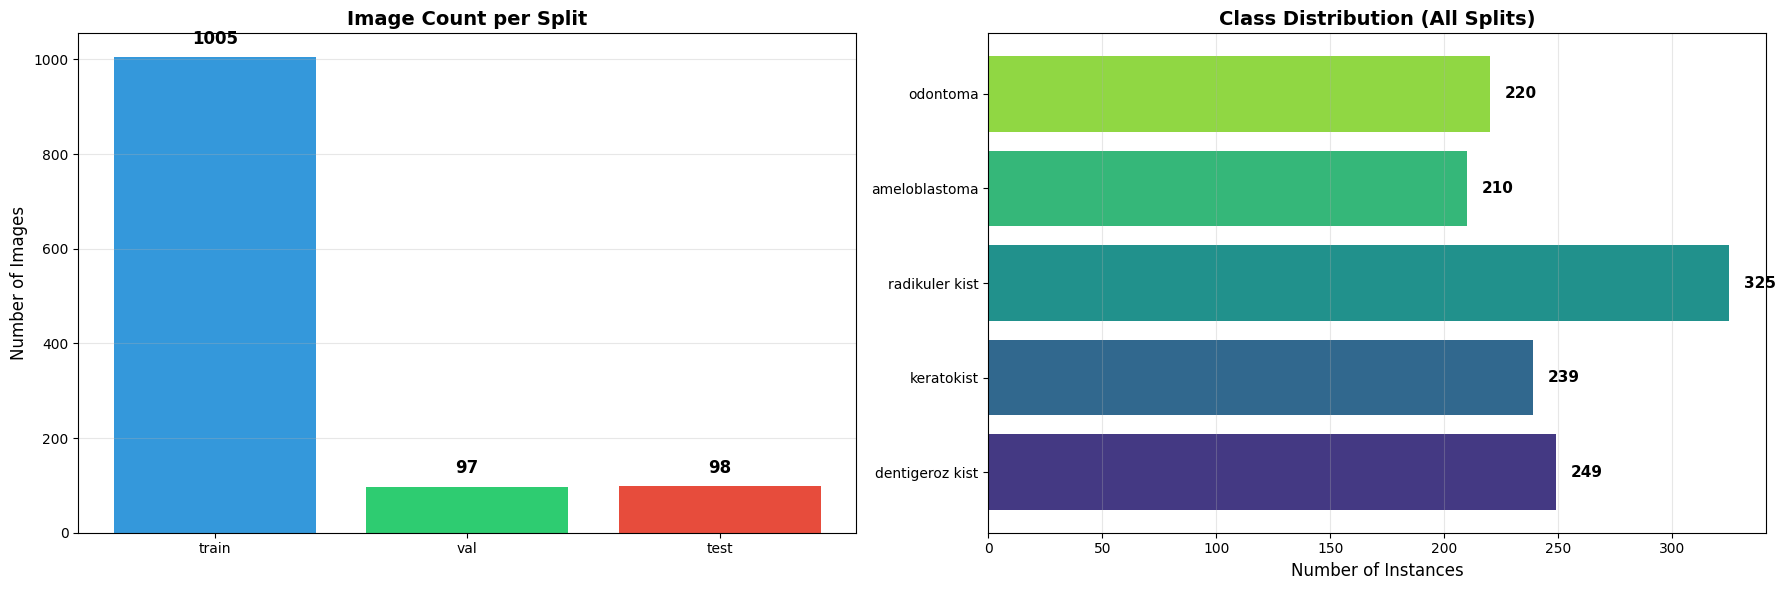

In [17]:
try:
    data_config, dataset_stats = analyze_dataset(data_yaml_path)
except Exception as e:
    print(f"⚠️  Dataset analizi yapılamadı: {e}")
    print("Lütfen data.yaml ve veri seti yapınızı kontrol edin.")

In [18]:
def train_yolo_segmentation(config):
    """
    YOLO segmentation modelini eğit
    """
    print("\n" + "="*70)
    print(f"🚀 Training Started")
    print("="*70)
    print(f"Run name: {config['run_name']}")
    print(f"Model: {config['model_name']}")
    print(f"Device: {config['device']}")
    print(f"Epochs: {config['epochs']}")
    print(f"Batch size: {config['batch']}")
    print(f"Image size: {config['imgsz']}")
    print("="*70 + "\n")

    # Model yükle
    model = YOLO(config['model_name'])

    # Run directory
    project_dir = RUNS_DIR / config['project_name']

    # Eğitim parametreleri
    train_args = {
        'data': config['data_yaml'],
        'epochs': config['epochs'],
        'imgsz': config['imgsz'],
        'batch': config['batch'],
        'device': config['device'],
        'patience': config['patience'],
        'save': True,
        'save_period': config['save_period'],
        'project': str(project_dir),
        'name': config['run_name'],
        'exist_ok': True,
        'pretrained': True,
        'optimizer': 'AdamW',
        'lr0': 0.001,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
        'plots': True,
        'verbose': True,
        'cache': False,
        'workers': config['workers'],
        'amp': True,
    }

    # Eğitimi başlat
    results = model.train(**train_args)

    # Model yolları
    run_dir = project_dir / config['run_name']
    best_model_path = run_dir / 'weights' / 'best.pt'
    last_model_path = run_dir / 'weights' / 'last.pt'

    print("\n" + "="*70)
    print(f"✅ Training Completed!")
    print("="*70)
    print(f"📁 Results directory: {run_dir}")
    print(f"🏆 Best model: {best_model_path}")
    print(f"🔄 Last model: {last_model_path}")
    print("="*70 + "\n")

    return results, best_model_path, run_dir

In [19]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [20]:
try:
    training_results, best_model_path, run_dir = train_yolo_segmentation(CONFIG)
except Exception as e:
    print(f"❌ Training error: {e}")
    raise


🚀 Training Started
Run name: run_20251115_194558
Model: yolov8n-seg.pt
Device: 0
Epochs: 3
Batch size: 1
Image size: 320

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data_v2_aug/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run_20251


📊 Training Results Analysis



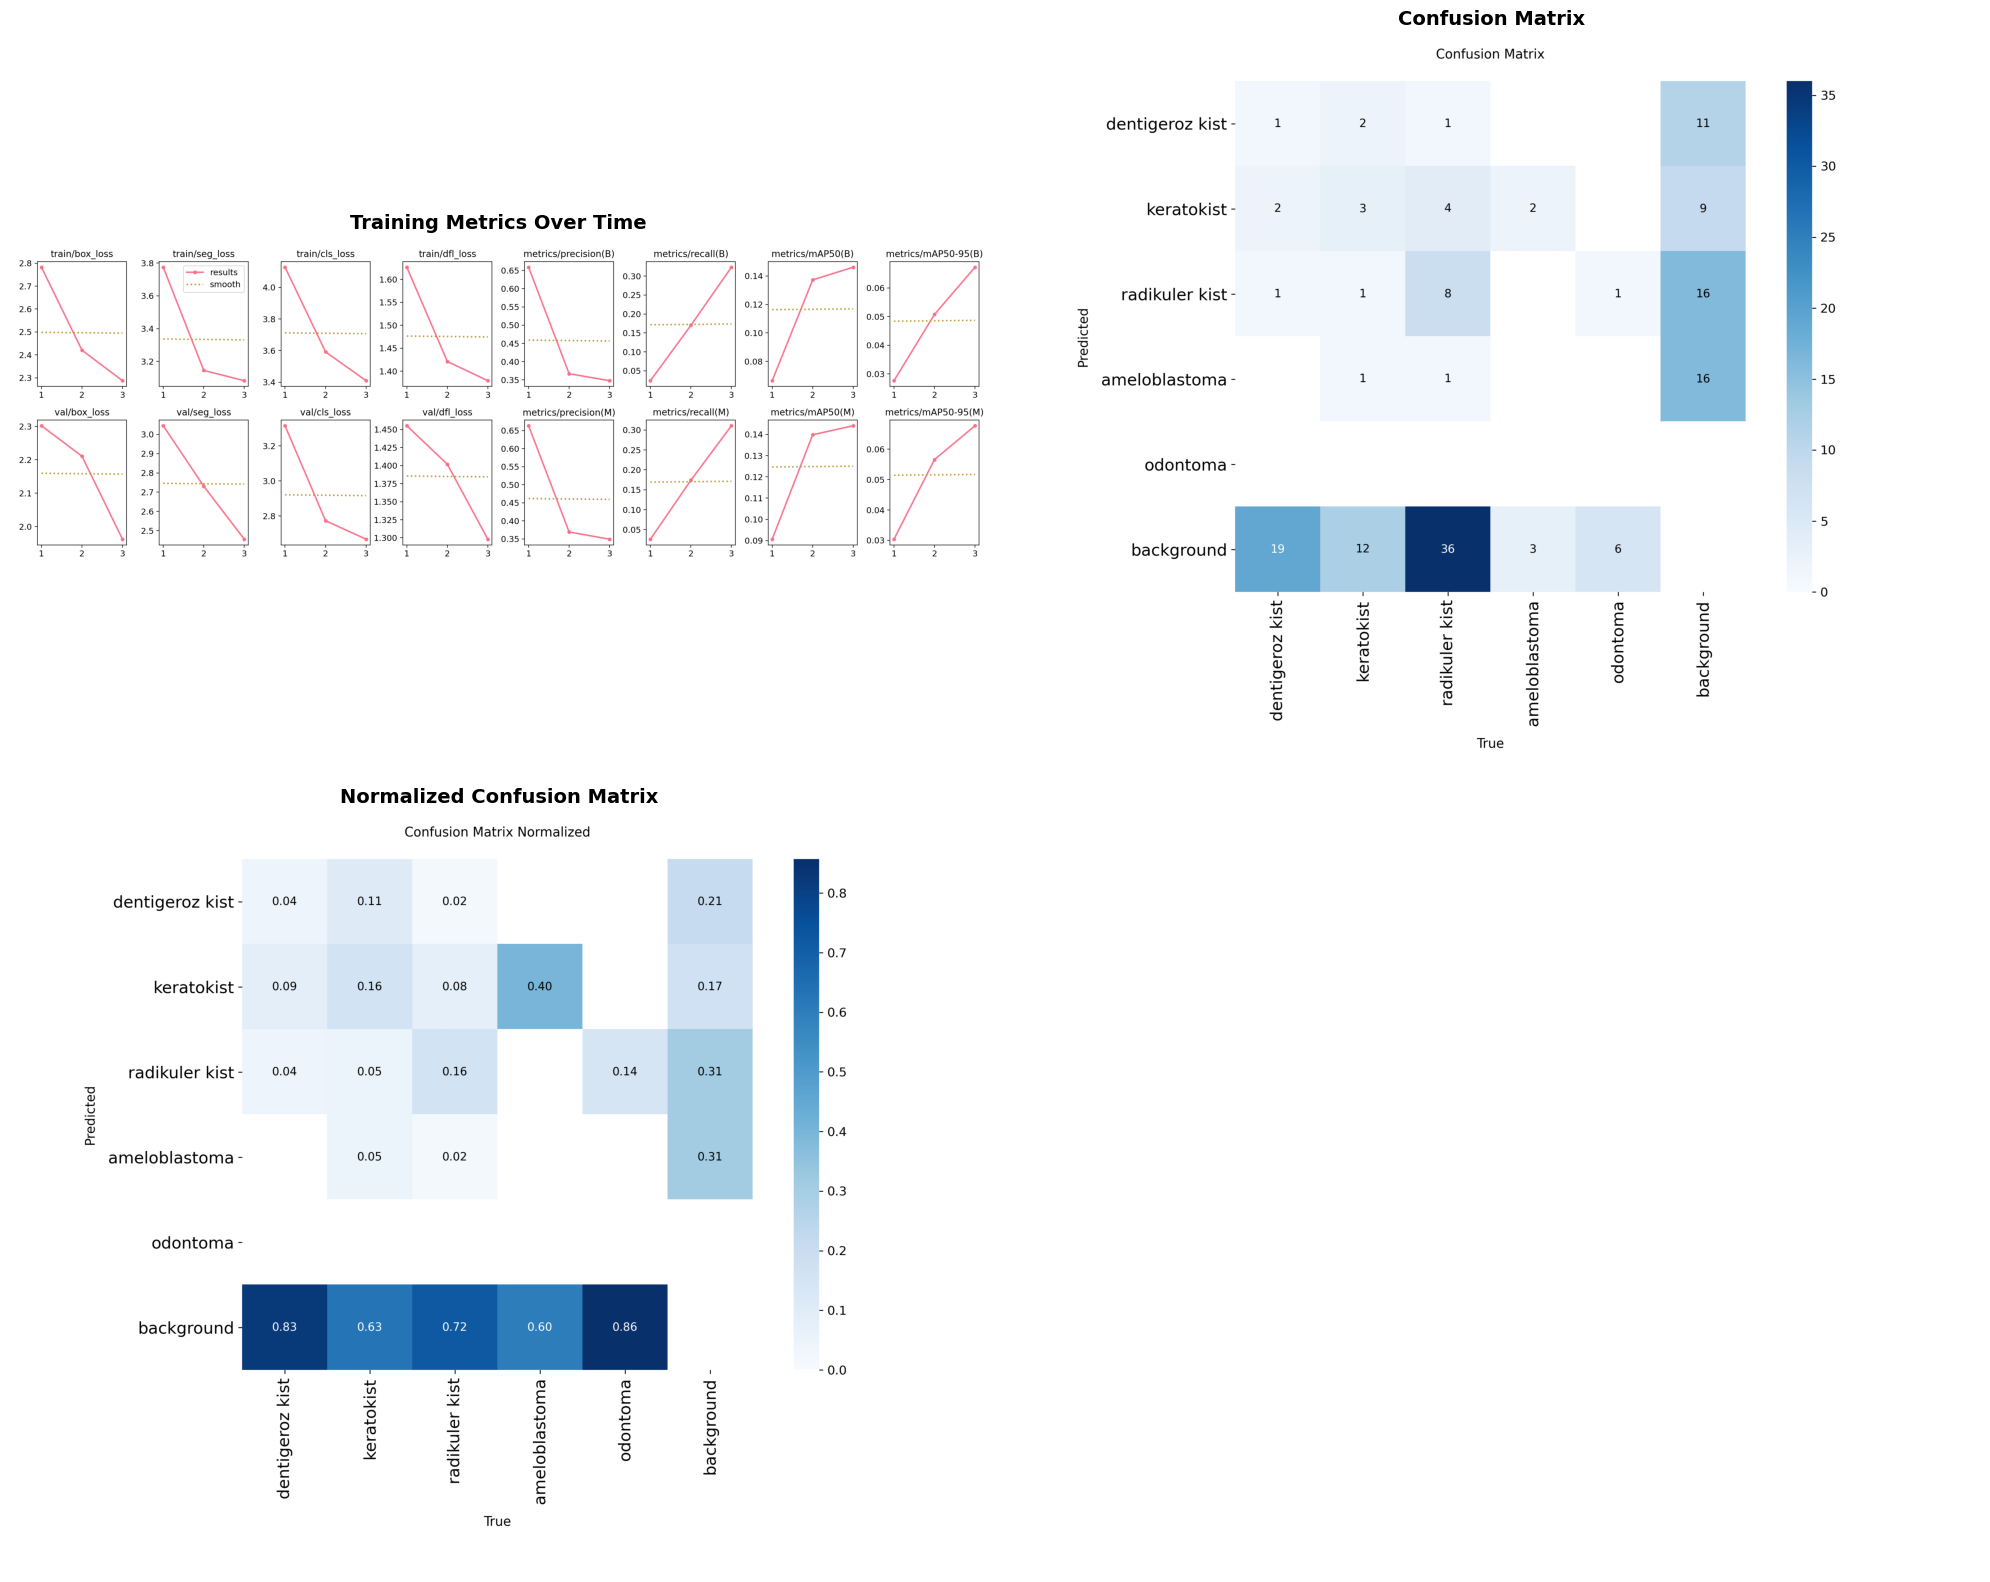


📈 Training Metrics Summary:
----------------------------------------------------------------------

Last 5 Epochs:
 epoch  train/box_loss  train/seg_loss  train/cls_loss  metrics/mAP50(B)  metrics/mAP50-95(B)
     1         2.78222         3.77465         4.12738           0.06647              0.02764
     2         2.42048         3.14505         3.59201           0.13725              0.05074
     3         2.28782         3.08238         3.40966           0.14614              0.06720

🎯 Final Training Metrics:
  Box mAP50           : 0.1461
  Box mAP50-95        : 0.0672
  Mask mAP50          : 0.1441
  Mask mAP50-95       : 0.0677
  Precision           : 0.3480
  Recall              : 0.3233



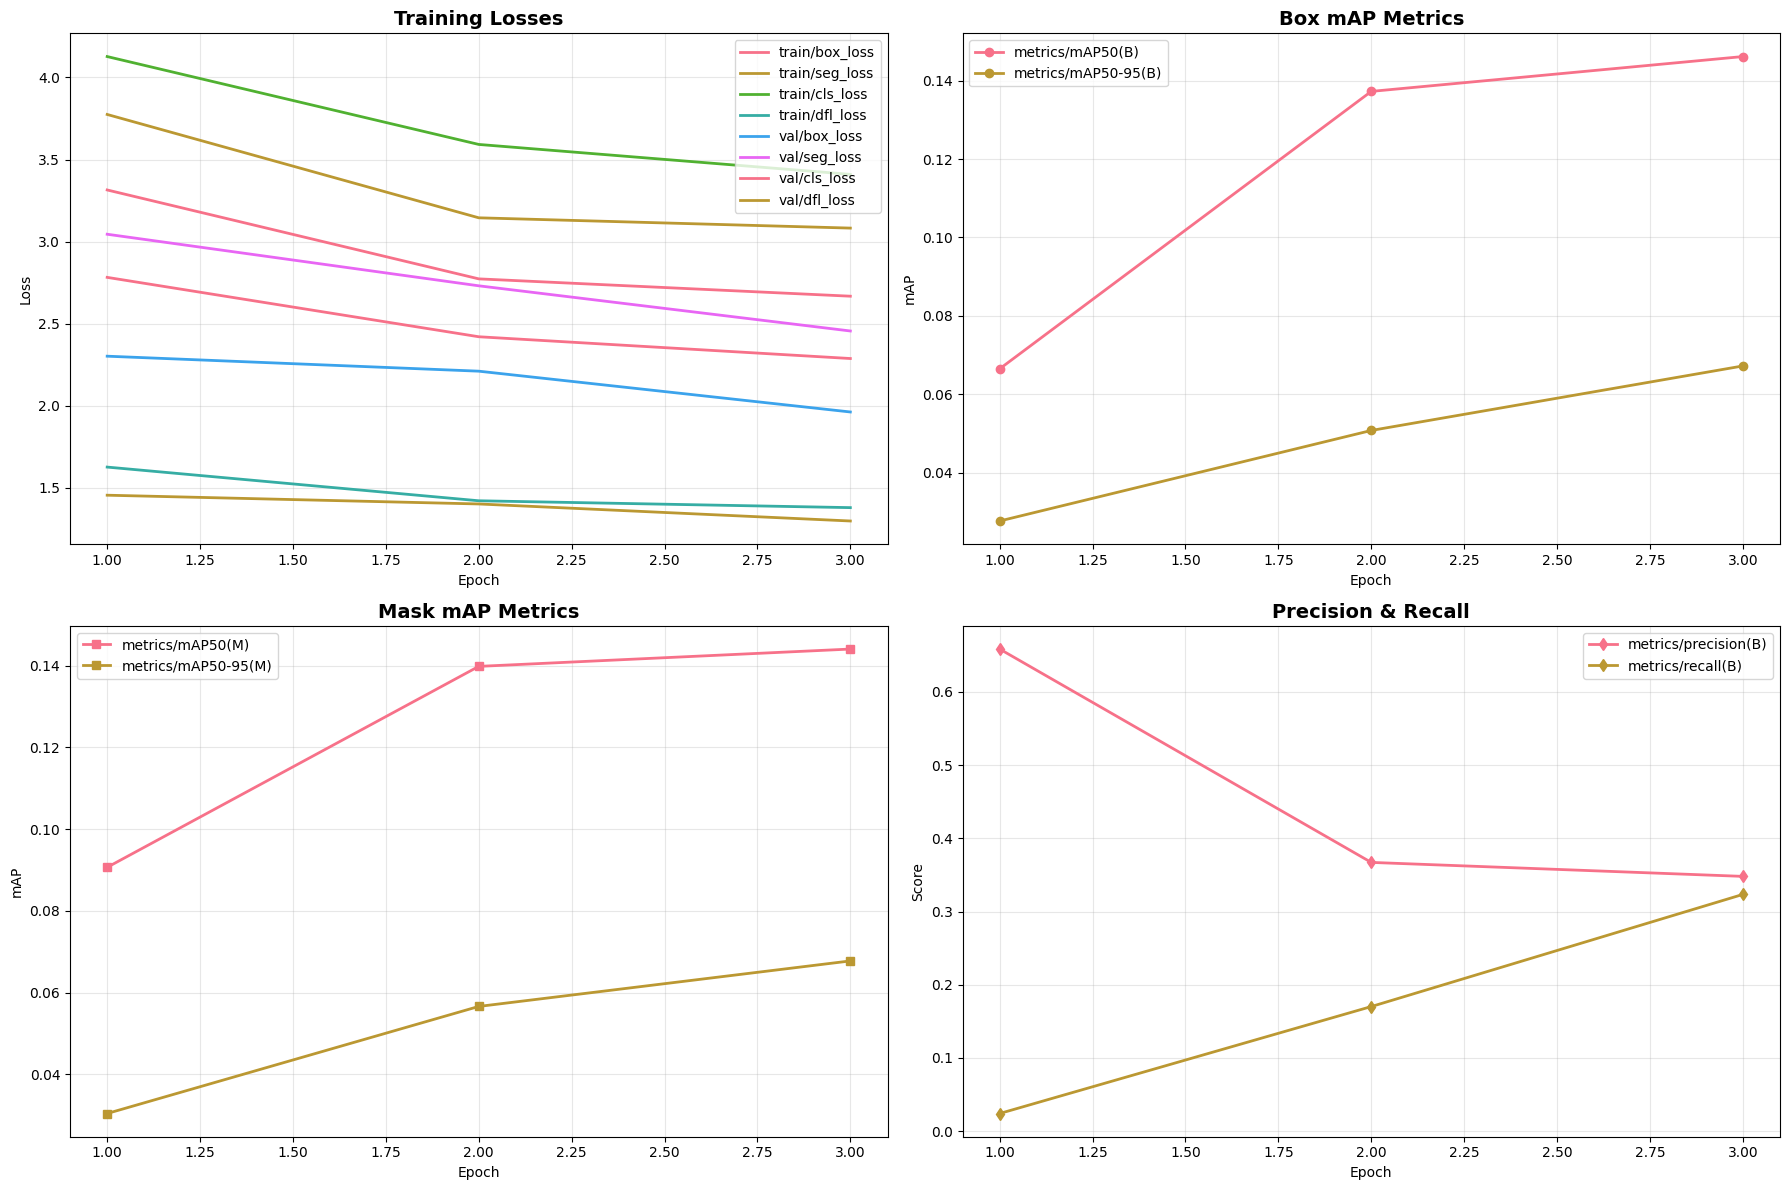

In [21]:
def display_training_results(run_dir):
    """
    Eğitim sonuçlarını detaylı şekilde görselleştir
    """
    print("\n" + "="*70)
    print("📊 Training Results Analysis")
    print("="*70 + "\n")

    # 1. Eğitim grafikleri
    plots = {
        'results.png': 'Training Metrics Over Time',
        'confusion_matrix.png': 'Confusion Matrix',
        'confusion_matrix_normalized.png': 'Normalized Confusion Matrix',
        'F1_curve.png': 'F1 Score vs Confidence',
        'P_curve.png': 'Precision vs Confidence',
        'R_curve.png': 'Recall vs Confidence',
        'PR_curve.png': 'Precision-Recall Curve',
    }

    available_plots = {k: v for k, v in plots.items() if (run_dir / k).exists()}
    n_plots = len(available_plots)

    if n_plots > 0:
        cols = 2
        rows = (n_plots + 1) // 2
        fig, axes = plt.subplots(rows, cols, figsize=(20, 8*rows))
        axes = axes.flatten() if n_plots > 1 else [axes]

        for idx, (filename, title) in enumerate(available_plots.items()):
            plot_path = run_dir / filename
            img = cv2.imread(str(plot_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            axes[idx].set_title(title, fontsize=14, fontweight='bold', pad=10)
            axes[idx].axis('off')

        # Boş subplot'ları gizle
        for idx in range(len(available_plots), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.savefig(run_dir / 'combined_training_results.png', dpi=150, bbox_inches='tight')
        plt.show()

    # 2. Training CSV sonuçları
    results_csv = run_dir / 'results.csv'
    if results_csv.exists():
        df = pd.read_csv(results_csv)
        df.columns = df.columns.str.strip()

        print("\n📈 Training Metrics Summary:")
        print("-" * 70)

        # Son 5 epoch'u göster
        print("\nLast 5 Epochs:")
        display_cols = ['epoch', 'train/box_loss', 'train/seg_loss', 'train/cls_loss',
                       'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
        display_cols = [col for col in display_cols if col in df.columns]

        if display_cols:
            print(df[display_cols].tail(5).to_string(index=False))

        # Final metrics
        print("\n" + "="*70)
        print("🎯 Final Training Metrics:")
        print("="*70)
        final_metrics = df.iloc[-1]

        metrics_to_show = {
            'Box mAP50': 'metrics/mAP50(B)',
            'Box mAP50-95': 'metrics/mAP50-95(B)',
            'Mask mAP50': 'metrics/mAP50(M)',
            'Mask mAP50-95': 'metrics/mAP50-95(M)',
            'Precision': 'metrics/precision(B)',
            'Recall': 'metrics/recall(B)',
        }

        for name, col in metrics_to_show.items():
            if col in df.columns:
                print(f"  {name:20s}: {final_metrics[col]:.4f}")

        print("="*70 + "\n")

        # Metrics grafiği
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))

        # Loss curves
        loss_cols = [col for col in df.columns if 'loss' in col.lower()]
        if loss_cols:
            for col in loss_cols:
                axes[0, 0].plot(df['epoch'], df[col], label=col, linewidth=2)
            axes[0, 0].set_title('Training Losses', fontsize=14, fontweight='bold')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            axes[0, 0].grid(alpha=0.3)

        # mAP curves (Box)
        map_cols = [col for col in df.columns if 'mAP' in col and '(B)' in col]
        if map_cols:
            for col in map_cols:
                axes[0, 1].plot(df['epoch'], df[col], label=col, linewidth=2, marker='o')
            axes[0, 1].set_title('Box mAP Metrics', fontsize=14, fontweight='bold')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('mAP')
            axes[0, 1].legend()
            axes[0, 1].grid(alpha=0.3)

        # mAP curves (Mask)
        mask_cols = [col for col in df.columns if 'mAP' in col and '(M)' in col]
        if mask_cols:
            for col in mask_cols:
                axes[1, 0].plot(df['epoch'], df[col], label=col, linewidth=2, marker='s')
            axes[1, 0].set_title('Mask mAP Metrics', fontsize=14, fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('mAP')
            axes[1, 0].legend()
            axes[1, 0].grid(alpha=0.3)

        # Precision & Recall
        pr_cols = ['metrics/precision(B)', 'metrics/recall(B)']
        pr_cols = [col for col in pr_cols if col in df.columns]
        if pr_cols:
            for col in pr_cols:
                axes[1, 1].plot(df['epoch'], df[col], label=col, linewidth=2, marker='d')
            axes[1, 1].set_title('Precision & Recall', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Score')
            axes[1, 1].legend()
            axes[1, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(run_dir / 'metrics_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()

# %%
display_training_results(run_dir)

In [22]:
def validate_model_detailed(model_path, data_yaml, device='0'):
    """
    Modeli validation seti üzerinde detaylı değerlendir
    """
    print("\n" + "="*70)
    print(f"🔍 Detailed Validation Analysis")
    print("="*70 + "\n")

    model = YOLO(model_path)

    # Validation yap
    metrics = model.val(
        data=data_yaml,
        split='val',
        imgsz=640,
        batch=4,
        device=device,
        plots=True,
        save_json=True,
        verbose=True
    )

    # Detaylı sonuçlar
    print("\n" + "="*70)
    print("📊 Validation Metrics Summary")
    print("="*70 + "\n")

    print("Box Detection Metrics:")
    print(f"  mAP50:     {metrics.box.map50:.4f}")
    print(f"  mAP50-95:  {metrics.box.map:.4f}")
    print(f"  mAP75:     {metrics.box.map75:.4f}")
    print(f"  Precision: {metrics.box.mp:.4f}")
    print(f"  Recall:    {metrics.box.mr:.4f}")

    print("\nSegmentation Metrics:")
    print(f"  mAP50:     {metrics.seg.map50:.4f}")
    print(f"  mAP50-95:  {metrics.seg.map:.4f}")
    print(f"  mAP75:     {metrics.seg.map75:.4f}")
    print(f"  Precision: {metrics.seg.mp:.4f}")
    print(f"  Recall:    {metrics.seg.mr:.4f}")

    # Per-class metrics
    if hasattr(metrics.box, 'ap_class_index'):
        print("\n" + "-"*70)
        print("Per-Class Box Detection mAP50:")
        print("-"*70)
        class_names = model.names
        for idx, class_id in enumerate(metrics.box.ap_class_index):
            class_map = metrics.box.ap50[idx]
            print(f"  {class_names[class_id]:20s}: {class_map:.4f}")

    if hasattr(metrics.seg, 'ap_class_index'):
        print("\n" + "-"*70)
        print("Per-Class Segmentation mAP50:")
        print("-"*70)
        for idx, class_id in enumerate(metrics.seg.ap_class_index):
            class_map = metrics.seg.ap50[idx]
            print(f"  {class_names[class_id]:20s}: {class_map:.4f}")

    print("\n" + "="*70 + "\n")

    # Metrics görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Box vs Seg karşılaştırması
    metrics_comparison = {
        'mAP50': [metrics.box.map50, metrics.seg.map50],
        'mAP50-95': [metrics.box.map, metrics.seg.map],
        'Precision': [metrics.box.mp, metrics.seg.mp],
        'Recall': [metrics.box.mr, metrics.seg.mr]
    }

    x = np.arange(len(metrics_comparison))
    width = 0.35

    box_values = [v[0] for v in metrics_comparison.values()]
    seg_values = [v[1] for v in metrics_comparison.values()]

    bars1 = axes[0].bar(x - width/2, box_values, width, label='Box', color='#3498db')
    bars2 = axes[0].bar(x + width/2, seg_values, width, label='Seg', color='#e74c3c')

    axes[0].set_title('Box vs Segmentation Metrics', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics_comparison.keys())
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim(0, 1.0)

    # Değerleri bar'ların üzerine yaz
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    # Per-class mAP50 karşılaştırması
    if hasattr(metrics.box, 'ap_class_index'):
        class_names_list = [class_names[i] for i in metrics.box.ap_class_index]
        box_map50_per_class = metrics.box.ap50
        seg_map50_per_class = metrics.seg.ap50 if hasattr(metrics.seg, 'ap50') else [0] * len(box_map50_per_class)

        x = np.arange(len(class_names_list))
        bars1 = axes[1].bar(x - width/2, box_map50_per_class, width, label='Box', color='#3498db')
        bars2 = axes[1].bar(x + width/2, seg_map50_per_class, width, label='Seg', color='#e74c3c')

        axes[1].set_title('Per-Class mAP50', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('mAP50', fontsize=12)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(class_names_list, rotation=45, ha='right')
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)
        axes[1].set_ylim(0, 1.0)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'validation_metrics_detailed.png', dpi=150, bbox_inches='tight')
    plt.show()

    return metrics


🔍 Detailed Validation Analysis

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,259,039 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2837.3±234.4 MB/s, size: 3543.9 KB)
val: Scanning /content/data/data_v2_aug/valid/labels.cache... 97 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 97/97 201.1Kit/s 0.0s
requirements: Ultralytics requirement ['faster-coco-eval>=1.6.7'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 148ms
Prepared 1 package in 46ms
Installed 1 package in 2ms
 + faster-coco-eval==1.7.0

requirements: AutoUpdate success ✅ 1.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 15.1s/it 12:20
                  

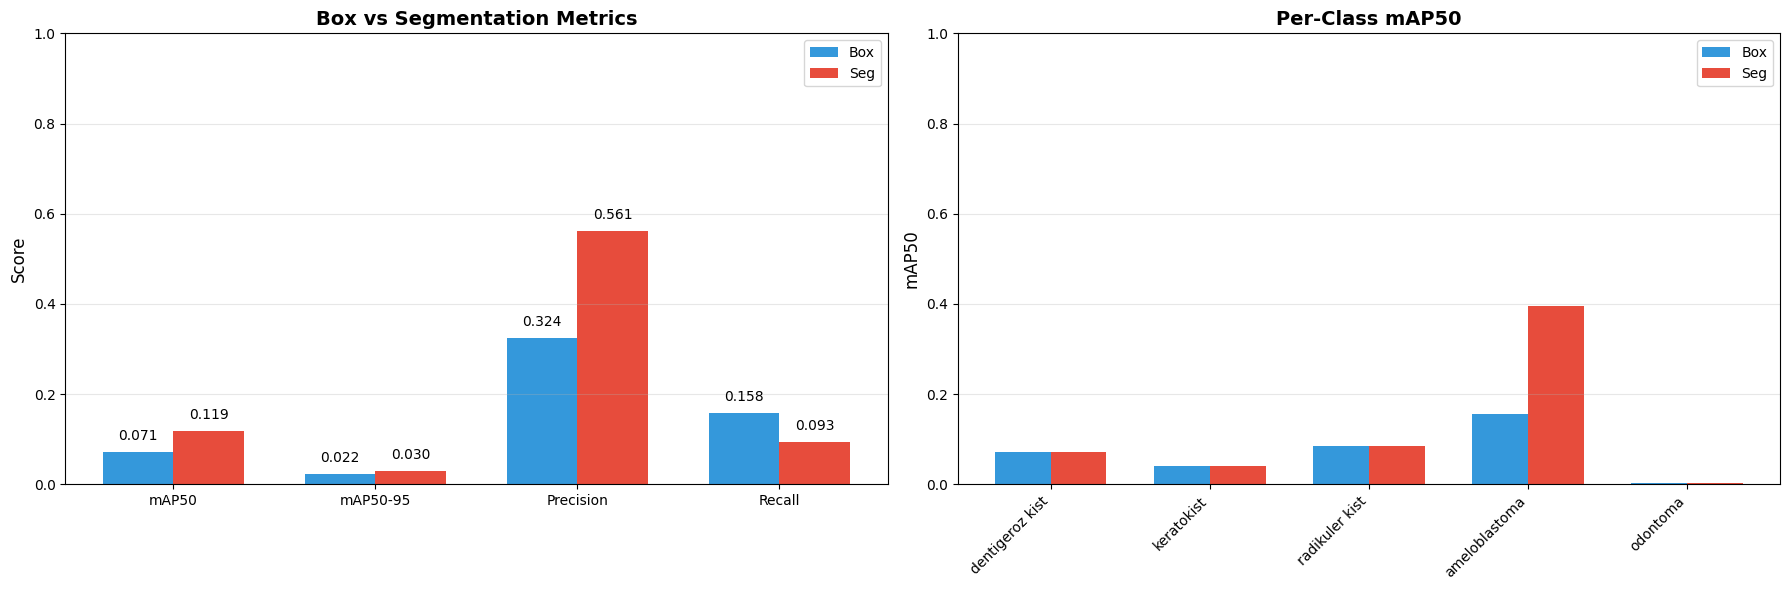

In [23]:
val_metrics = validate_model_detailed(
    model_path=best_model_path,
    data_yaml=CONFIG['data_yaml'],
    device=CONFIG['device']
)

In [24]:
def evaluate_test_set(model_path, data_yaml, device='0'):
    """
    Test seti üzerinde kapsamlı değerlendirme
    """
    print("\n" + "="*70)
    print(f"🧪 Test Set Evaluation")
    print("="*70 + "\n")

    model = YOLO(model_path)

    # Test split'i kontrol et
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)

    if 'test' not in data_config:
        print("⚠️  Test split bulunamadı. Validation seti kullanılıyor.")
        test_split = 'val'
    else:
        test_split = 'test'

    # Test evaluation
    test_metrics = model.val(
        data=data_yaml,
        split=test_split,
        imgsz=640,
        batch=4,
        device=device,
        plots=True,
        save_json=True,
        verbose=True
    )

    print("\n" + "="*70)
    print("📊 Test Set Results")
    print("="*70 + "\n")

    print("Box Detection Metrics:")
    print(f"  mAP50:     {test_metrics.box.map50:.4f}")
    print(f"  mAP50-95:  {test_metrics.box.map:.4f}")
    print(f"  Precision: {test_metrics.box.mp:.4f}")
    print(f"  Recall:    {test_metrics.box.mr:.4f}")

    print("\nSegmentation Metrics:")
    print(f"  mAP50:     {test_metrics.seg.map50:.4f}")
    print(f"  mAP50-95:  {test_metrics.seg.map:.4f}")
    print(f"  Precision: {test_metrics.seg.mp:.4f}")
    print(f"  Recall:    {test_metrics.seg.mr:.4f}")

    print("\n" + "="*70 + "\n")

    return test_metrics

In [25]:
test_metrics = evaluate_test_set(
    model_path=best_model_path,
    data_yaml=CONFIG['data_yaml'],
    device=CONFIG['device']
)


🧪 Test Set Evaluation

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,259,039 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 124.4±45.1 MB/s, size: 3217.7 KB)
val: Scanning /content/data/data_v2_aug/test/labels... 98 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 98/98 341.7it/s 0.3s
val: New cache created: /content/data/data_v2_aug/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 31.5s/it 13:07
                   all         98        103      0.248      0.117     0.0212    0.00949      0.256      0.126     0.0228    0.00961
       dentigeroz kist         23         24     0.0322      0.125     0.0117    0.00482     0.0444      0.167     0.0168    0.00494
            keratokist         19         19     0.0351      0.158      0.015     0.

In [26]:
def predict_single_image_detailed(model_path, image_path, conf_threshold=0.25, save_dir=None):
    """
    Tek görüntü üzerinde detaylı tahmin ve görselleştirme
    """
    print("\n" + "="*70)
    print(f"🎯 Detailed Prediction Analysis")
    print("="*70)
    print(f"Image: {Path(image_path).name}")
    print(f"Confidence threshold: {conf_threshold}")
    print("="*70 + "\n")

    model = YOLO(model_path)

    # Tahmin yap
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        iou=0.7,
        imgsz=640,
        device=CONFIG['device'],
        verbose=False
    )

    result = results[0]

    # Orijinal görüntüyü yükle
    original_img = cv2.imread(str(image_path))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Tahmin sonucunu çiz
    predicted_img = result.plot()
    predicted_img = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2RGB)

    # Detaylı görselleştirme
    fig = plt.figure(figsize=(22, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # 1. Orijinal görüntü
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original_img)
    ax1.set_title('Original Image', fontsize=14, fontweight='bold', pad=10)
    ax1.axis('off')

    # 2. Tam tahmin sonucu
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(predicted_img)
    ax2.set_title(f'Predictions (conf > {conf_threshold})', fontsize=14, fontweight='bold', pad=10)
    ax2.axis('off')

    # 3. Sadece maskeler
    ax3 = fig.add_subplot(gs[0, 2])
    if result.masks is not None:
        mask_overlay = original_img.copy()
        colors = plt.cm.tab10(np.linspace(0, 1, 10))

        for idx, (mask, cls) in enumerate(zip(result.masks.data.cpu().numpy(), result.boxes.cls)):
            color = colors[int(cls) % 10][:3]
            color_mask = (np.array(color) * 255).astype(np.uint8)

            # Resize mask to original image size
            mask_resized = cv2.resize(mask, (original_img.shape[1], original_img.shape[0]))
            mask_bool = mask_resized > 0.5

            # Apply colored mask
            for c in range(3):
                mask_overlay[:, :, c] = np.where(
                    mask_bool,
                    mask_overlay[:, :, c] * 0.5 + color_mask[c] * 0.5,
                    mask_overlay[:, :, c]
                )

        ax3.imshow(mask_overlay)
        ax3.set_title('Segmentation Masks Only', fontsize=14, fontweight='bold', pad=10)
    else:
        ax3.text(0.5, 0.5, 'No masks detected', ha='center', va='center', fontsize=14)
    ax3.axis('off')

    # 4. Detection statistics
    ax4 = fig.add_subplot(gs[1, :])
    ax4.axis('off')

    if len(result.boxes) > 0:
        print(f"✅ Found {len(result.boxes)} detection(s)\n")

        # Detayları tabloya dönüştür
        detection_data = []
        for idx, (box, conf, cls) in enumerate(zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls)):
            class_name = model.names[int(cls)]
            x1, y1, x2, y2 = box.cpu().numpy()
            width = x2 - x1
            height = y2 - y1
            area = width * height

            detection_info = {
                'ID': idx + 1,
                'Class': class_name,
                'Confidence': f'{conf:.3f}',
                'BBox (x1,y1,x2,y2)': f'({x1:.0f},{y1:.0f},{x2:.0f},{y2:.0f})',
                'Width': f'{width:.0f}px',
                'Height': f'{height:.0f}px',
                'Area': f'{area:.0f}px²'
            }
            detection_data.append(detection_info)

            # Konsola da yazdır
            print(f"Detection {idx + 1}:")
            print(f"  Class: {class_name}")
            print(f"  Confidence: {conf:.3f}")
            print(f"  Bounding Box: ({x1:.0f}, {y1:.0f}) → ({x2:.0f}, {y2:.0f})")
            print(f"  Size: {width:.0f}x{height:.0f} px")

            if result.masks is not None:
                mask = result.masks.data[idx].cpu().numpy()
                mask_area = np.sum(mask > 0.5)
                print(f"  Mask Area: {mask_area:.0f} pixels")
            print()

        # Tablo oluştur
        df = pd.DataFrame(detection_data)

        table = ax4.table(
            cellText=df.values,
            colLabels=df.columns,
            cellLoc='center',
            loc='center',
            bbox=[0.1, 0.3, 0.8, 0.6]
        )

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)

        # Header styling
        for i in range(len(df.columns)):
            cell = table[(0, i)]
            cell.set_facecolor('#3498db')
            cell.set_text_props(weight='bold', color='white')

        # Alternating row colors
        for i in range(1, len(df) + 1):
            for j in range(len(df.columns)):
                cell = table[(i, j)]
                if i % 2 == 0:
                    cell.set_facecolor('#ecf0f1')

        ax4.set_title('Detection Details', fontsize=14, fontweight='bold', pad=20, loc='center')
    else:
        ax4.text(0.5, 0.5, '⚠️ No detections found!',
                ha='center', va='center', fontsize=16, fontweight='bold')
        print("⚠️ No detections found!")

    plt.tight_layout()

    # Kaydet
    if save_dir:
        save_path = Path(save_dir) / f'prediction_{Path(image_path).stem}_detailed.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n💾 Saved detailed prediction to: {save_path}")

    plt.show()

    return result


🖼️  Selected test image: A108.png


🎯 Detailed Prediction Analysis
Image: A108.png
Confidence threshold: 0.25

✅ Found 3 detection(s)

Detection 1:
  Class: dentigeroz kist
  Confidence: 0.759
  Bounding Box: (453, 426) → (644, 505)
  Size: 192x79 px
  Mask Area: 5289 pixels

Detection 2:
  Class: ameloblastoma
  Confidence: 0.710
  Bounding Box: (456, 425) → (676, 511)
  Size: 220x86 px
  Mask Area: 6317 pixels

Detection 3:
  Class: ameloblastoma
  Confidence: 0.258
  Bounding Box: (459, 427) → (612, 501)
  Size: 153x75 px
  Mask Area: 4181 pixels



/tmp/ipython-input-875323359.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



💾 Saved detailed prediction to: /content/results/prediction_A108_detailed.png


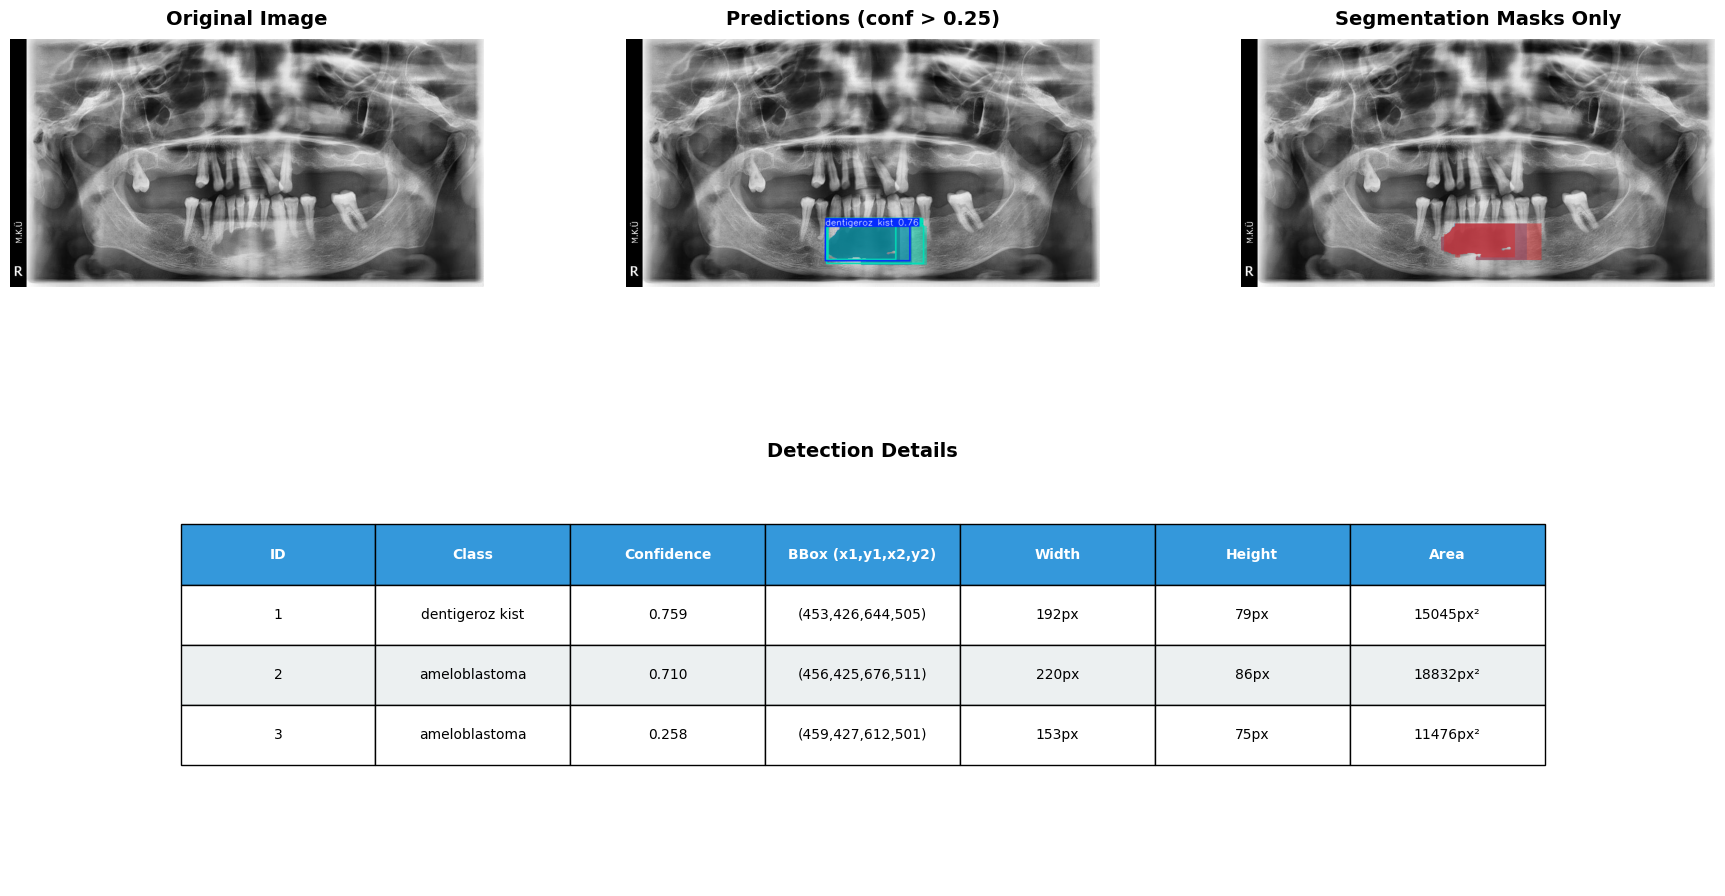

In [27]:
# Test setinden bir görüntü seç ve detaylı tahmin yap
with open(CONFIG['data_yaml'], 'r') as f:
    data_config = yaml.safe_load(f)
    test_split = data_config.get('test', data_config['val'])
    test_images_dir = Path(data_config['path']) / test_split

# İlk test görüntüsünü bul
test_images = sorted(list(test_images_dir.glob('*.jpg')) + list(test_images_dir.glob('*.png')))

if test_images:
    test_image = test_images[0]
    print(f"\n🖼️  Selected test image: {test_image.name}\n")

    prediction_result = predict_single_image_detailed(
        model_path=best_model_path,
        image_path=str(test_image),
        conf_threshold=0.25,
        save_dir=RESULTS_DIR
    )
else:
    print("⚠️ No test images found!")


📸 Batch Prediction Analysis
Total images: 9
Confidence threshold: 0.25

✓ A108.png: 0 detection(s)
✓ A122.png: 0 detection(s)
✓ A129.png: 0 detection(s)
✓ A130.png: 2 detection(s)
✓ A152.png: 1 detection(s)
✓ A285.png: 5 detection(s)
✓ A314.png: 0 detection(s)
✓ A551.png: 0 detection(s)
✓ A764.png: 3 detection(s)


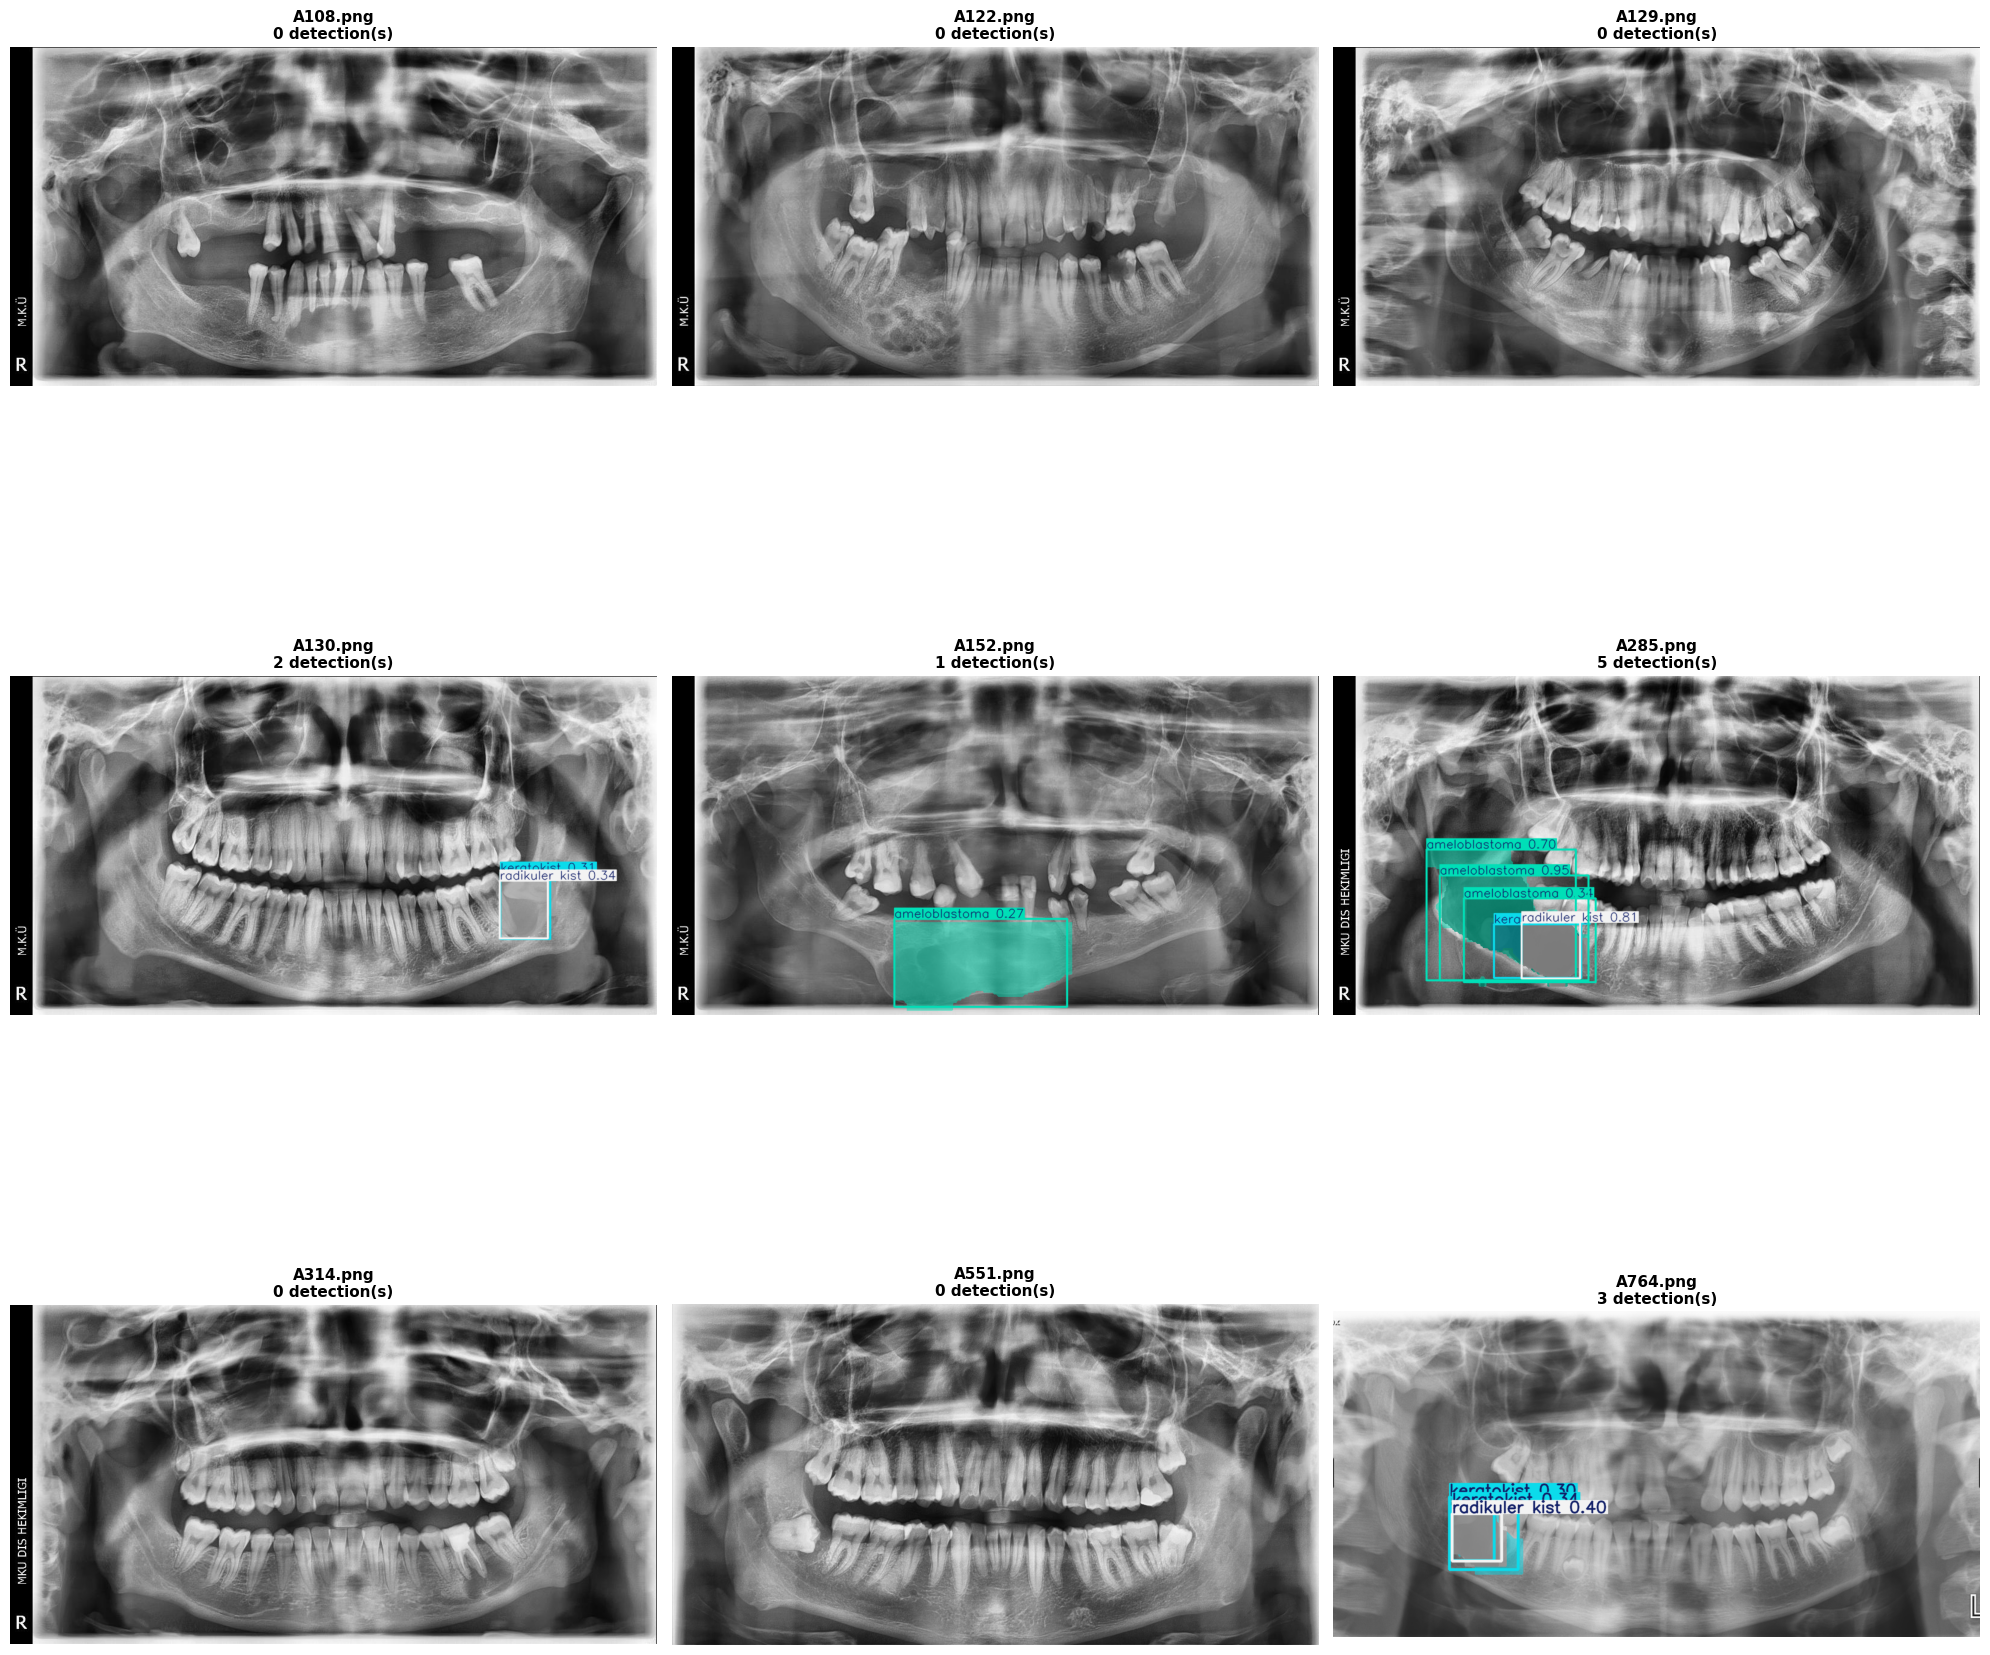


📊 Batch Prediction Statistics
Total detections: 11
Average detections per image: 1.22

Confidence Score Statistics:
  Mean: 0.468
  Median: 0.337
  Min: 0.268
  Max: 0.948

Class Distribution:
  keratokist          :   4 ( 36.4%)
  ameloblastoma       :   4 ( 36.4%)
  radikuler kist      :   3 ( 27.3%)



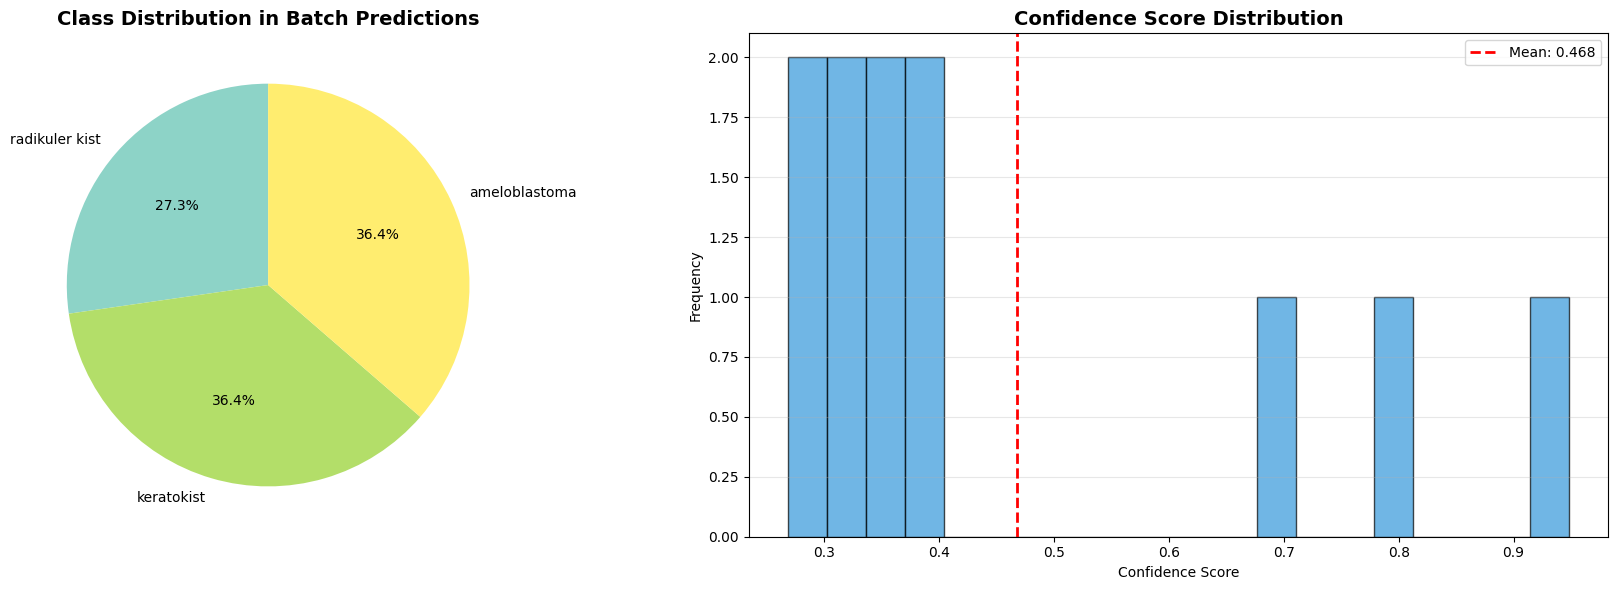

In [28]:
def batch_predict_with_analysis(model_path, test_images_dir, num_samples=6, conf_threshold=0.25):
    """
    Birden fazla test görüntüsü üzerinde toplu tahmin ve analiz
    """
    model = YOLO(model_path)

    # Test görüntülerini al
    test_images = sorted(list(Path(test_images_dir).glob('*.jpg')) +
                        list(Path(test_images_dir).glob('*.png')))

    if not test_images:
        print("⚠️ No test images found!")
        return

    # Görüntüleri seç
    selected_images = test_images[:min(num_samples, len(test_images))]

    print("\n" + "="*70)
    print(f"📸 Batch Prediction Analysis")
    print("="*70)
    print(f"Total images: {len(selected_images)}")
    print(f"Confidence threshold: {conf_threshold}")
    print("="*70 + "\n")

    # İstatistikler
    total_detections = 0
    class_counts = defaultdict(int)
    confidence_scores = []

    # Grid görselleştirme
    cols = 3
    rows = (len(selected_images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 7*rows))
    axes = axes.flatten() if len(selected_images) > 1 else [axes]

    for idx, img_path in enumerate(selected_images):
        # Tahmin yap
        results = model.predict(
            source=str(img_path),
            conf=conf_threshold,
            device=CONFIG['device'],
            verbose=False
        )

        result = results[0]
        n_detections = len(result.boxes)
        total_detections += n_detections

        # Sınıf ve confidence istatistikleri
        for cls, conf in zip(result.boxes.cls, result.boxes.conf):
            class_name = model.names[int(cls)]
            class_counts[class_name] += 1
            confidence_scores.append(conf.item())

        # Görselleştir
        result_img = result.plot()
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(result_img)
        axes[idx].set_title(f'{img_path.name}\n{n_detections} detection(s)',
                           fontsize=11, fontweight='bold')
        axes[idx].axis('off')

        print(f"✓ {img_path.name}: {n_detections} detection(s)")

    # Boş subplot'ları gizle
    for idx in range(len(selected_images), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'batch_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

    # İstatistik özeti
    print("\n" + "="*70)
    print("📊 Batch Prediction Statistics")
    print("="*70)
    print(f"Total detections: {total_detections}")
    print(f"Average detections per image: {total_detections / len(selected_images):.2f}")

    if confidence_scores:
        print(f"\nConfidence Score Statistics:")
        print(f"  Mean: {np.mean(confidence_scores):.3f}")
        print(f"  Median: {np.median(confidence_scores):.3f}")
        print(f"  Min: {np.min(confidence_scores):.3f}")
        print(f"  Max: {np.max(confidence_scores):.3f}")

    print(f"\nClass Distribution:")
    for class_name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_detections * 100) if total_detections > 0 else 0
        print(f"  {class_name:20s}: {count:3d} ({percentage:5.1f}%)")

    print("="*70 + "\n")

    # İstatistik grafikleri
    if class_counts and confidence_scores:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Class distribution
        classes = list(class_counts.keys())
        counts = list(class_counts.values())
        colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))

        axes[0].pie(counts, labels=classes, autopct='%1.1f%%', colors=colors, startangle=90)
        axes[0].set_title('Class Distribution in Batch Predictions',
                         fontsize=14, fontweight='bold')

        # Confidence distribution
        axes[1].hist(confidence_scores, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
        axes[1].axvline(np.mean(confidence_scores), color='red', linestyle='--',
                       linewidth=2, label=f'Mean: {np.mean(confidence_scores):.3f}')
        axes[1].set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Confidence Score')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'batch_statistics.png', dpi=150, bbox_inches='tight')
        plt.show()

# %%
# Batch prediction
if test_images:
    batch_predict_with_analysis(
        model_path=best_model_path,
        test_images_dir=test_images_dir,
        num_samples=9,
        conf_threshold=0.25
    )


📊 Validation vs Test Performance Comparison

Metric                 Validation         Test   Difference
----------------------------------------------------------------------
Box mAP50                  0.0711       0.0212      -0.0499
Box mAP50-95               0.0219       0.0095      -0.0124
Seg mAP50                  0.1189       0.0228      -0.0961
Seg mAP50-95               0.0301       0.0096      -0.0205
Precision                  0.3235       0.2480      -0.0756
Recall                     0.1584       0.1174      -0.0409



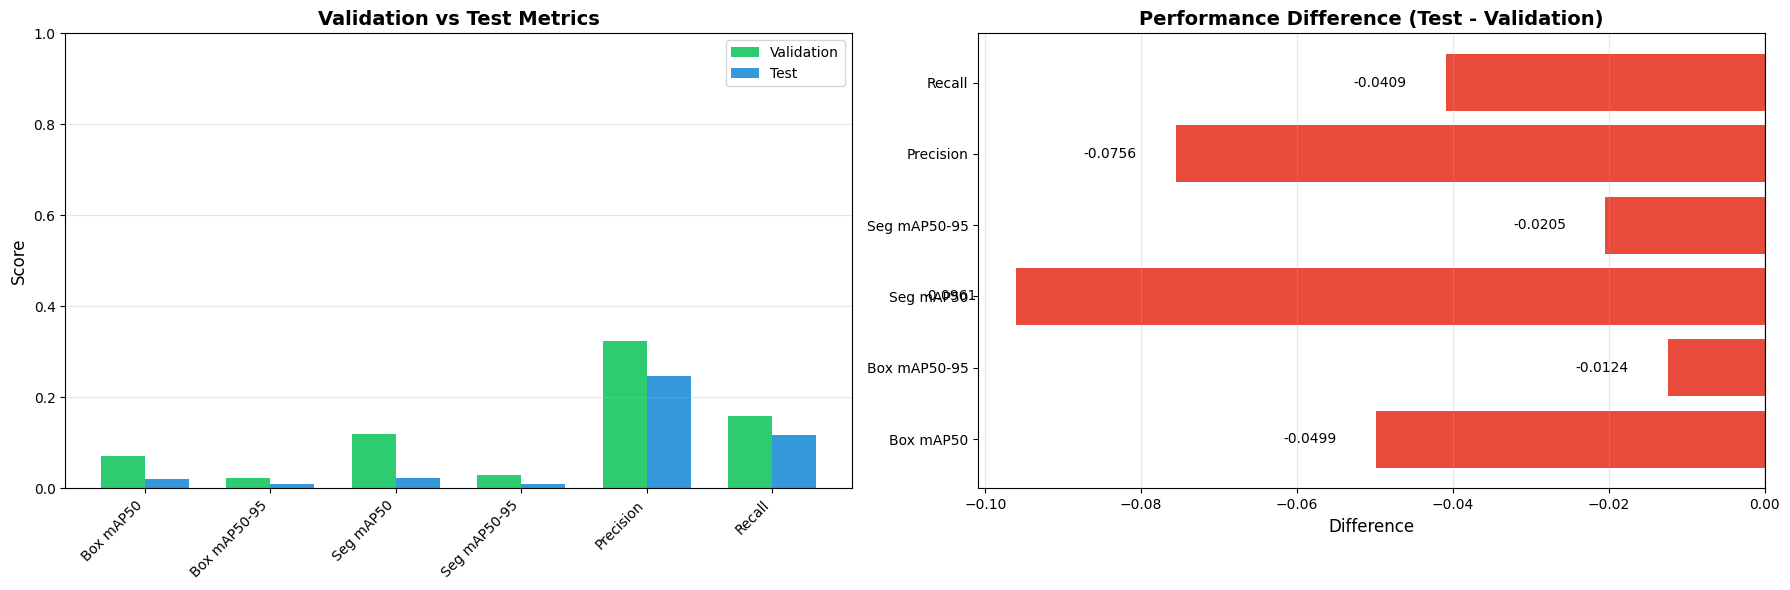

In [29]:
def compare_val_test_performance(val_metrics, test_metrics):
    """
    Validation ve test performansını karşılaştır
    """
    print("\n" + "="*70)
    print("📊 Validation vs Test Performance Comparison")
    print("="*70 + "\n")

    # Metrics comparison
    metrics_dict = {
        'Box mAP50': [val_metrics.box.map50, test_metrics.box.map50],
        'Box mAP50-95': [val_metrics.box.map, test_metrics.box.map],
        'Seg mAP50': [val_metrics.seg.map50, test_metrics.seg.map50],
        'Seg mAP50-95': [val_metrics.seg.map, test_metrics.seg.map],
        'Precision': [val_metrics.box.mp, test_metrics.box.mp],
        'Recall': [val_metrics.box.mr, test_metrics.box.mr],
    }

    # Tablo yazdır
    print(f"{'Metric':<20} {'Validation':>12} {'Test':>12} {'Difference':>12}")
    print("-" * 70)

    for metric_name, (val_score, test_score) in metrics_dict.items():
        diff = test_score - val_score
        diff_str = f"{diff:+.4f}"
        print(f"{metric_name:<20} {val_score:>12.4f} {test_score:>12.4f} {diff_str:>12}")

    print("="*70 + "\n")

    # Görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Bar chart comparison
    x = np.arange(len(metrics_dict))
    width = 0.35

    val_values = [v[0] for v in metrics_dict.values()]
    test_values = [v[1] for v in metrics_dict.values()]

    bars1 = axes[0].bar(x - width/2, val_values, width, label='Validation', color='#2ecc71')
    bars2 = axes[0].bar(x + width/2, test_values, width, label='Test', color='#3498db')

    axes[0].set_title('Validation vs Test Metrics', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics_dict.keys(), rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim(0, 1.0)

    # Difference plot
    differences = [test - val for val, test in metrics_dict.values()]
    colors = ['#e74c3c' if d < 0 else '#2ecc71' for d in differences]

    bars = axes[1].barh(list(metrics_dict.keys()), differences, color=colors)
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[1].set_title('Performance Difference (Test - Validation)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Difference', fontsize=12)
    axes[1].grid(axis='x', alpha=0.3)

    # Add value labels
    for bar, diff in zip(bars, differences):
        axes[1].text(diff + 0.005 if diff > 0 else diff - 0.005,
                    bar.get_y() + bar.get_height()/2,
                    f'{diff:+.4f}', va='center',
                    ha='left' if diff > 0 else 'right', fontsize=10)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'val_vs_test_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# %%
# Validation vs Test karşılaştırması
compare_val_test_performance(val_metrics, test_metrics)


In [ ]:
def export_model(model_path, export_format='onnx'):
    """
    Modeli farklı formatlara export et
    """
    print("\n" + "="*70)
    print(f"📦 Exporting model to {export_format.upper()}")
    print("="*70 + "\n")

    model = YOLO(model_path)
    export_path = model.export(format=export_format, imgsz=640)

    print(f"✅ Model exported successfully!")
    print(f"📁 Export path: {export_path}")
    print("="*70 + "\n")

    return export_path

# %%
# Model export (isteğe bağlı - uncomment to use)
# export_path = export_model(best_model_path, export_format='onnx')


In [30]:
def generate_final_report(config, val_metrics, test_metrics, run_dir, dataset_stats):
    """
    Tüm sonuçları içeren kapsamlı rapor oluştur
    """
    report = f"""
{'='*80}
                     YOLO DENTAL SEGMENTATION
                        FINAL TRAINING REPORT
{'='*80}

EXPERIMENT INFORMATION
{'='*80}
Project Name:        {config['project_name']}
Run Name:            {config['run_name']}
Date:                {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Model:               {config['model_name']}
Device:              {config['device']}

DATASET STATISTICS
{'='*80}
"""

    # Dataset statistics
    for split, stats in dataset_stats.items():
        report += f"\n{split.upper()} Set:\n"
        report += f"  Images:      {stats['images']:>6}\n"
        report += f"  Instances:   {stats['instances']:>6}\n"

    report += f"""
HYPERPARAMETERS
{'='*80}
Epochs:              {config['epochs']}
Batch Size:          {config['batch']}
Image Size:          {config['imgsz']}
Patience:            {config['patience']}
Optimizer:           AdamW
Initial LR:          0.001
Final LR:            0.01

VALIDATION RESULTS
{'='*80}
Box Detection:
  mAP50:             {val_metrics.box.map50:.4f}
  mAP50-95:          {val_metrics.box.map:.4f}
  Precision:         {val_metrics.box.mp:.4f}
  Recall:            {val_metrics.box.mr:.4f}

Segmentation:
  mAP50:             {val_metrics.seg.map50:.4f}
  mAP50-95:          {val_metrics.seg.map:.4f}
  Precision:         {val_metrics.seg.mp:.4f}
  Recall:            {val_metrics.seg.mr:.4f}

TEST RESULTS
{'='*80}
Box Detection:
  mAP50:             {test_metrics.box.map50:.4f}
  mAP50-95:          {test_metrics.box.map:.4f}
  Precision:         {test_metrics.box.mp:.4f}
  Recall:            {test_metrics.box.mr:.4f}

Segmentation:
  mAP50:             {test_metrics.seg.map50:.4f}
  mAP50-95:          {test_metrics.seg.map:.4f}
  Precision:         {test_metrics.seg.mp:.4f}
  Recall:            {test_metrics.seg.mr:.4f}

GENERALIZATION ANALYSIS
{'='*80}
Box mAP50 Gap:       {test_metrics.box.map50 - val_metrics.box.map50:+.4f}
Seg mAP50 Gap:       {test_metrics.seg.map50 - val_metrics.seg.map50:+.4f}

FILES AND OUTPUTS
{'='*80}
Run Directory:       {run_dir}
Best Model:          {run_dir / 'weights' / 'best.pt'}
Last Model:          {run_dir / 'weights' / 'last.pt'}
Results CSV:         {run_dir / 'results.csv'}

{'='*80}
                         END OF REPORT
{'='*80}
"""

    print(report)

    # Raporu kaydet
    report_path = RESULTS_DIR / f'final_report_{config["run_name"]}.txt'
    with open(report_path, 'w') as f:
        f.write(report)

    print(f"\n💾 Report saved to: {report_path}\n")

    return report

# %%
# Final report oluştur
final_report = generate_final_report(
    config=CONFIG,
    val_metrics=val_metrics,
    test_metrics=test_metrics,
    run_dir=run_dir,
    dataset_stats=dataset_stats
)


                     YOLO DENTAL SEGMENTATION
                        FINAL TRAINING REPORT

EXPERIMENT INFORMATION
Project Name:        dental_lesion
Run Name:            run_20251115_194558
Date:                2025-11-15 20:26:21
Model:               yolov8n-seg.pt
Device:              0

DATASET STATISTICS

TRAIN Set:
  Images:        1005
  Instances:     1036

VAL Set:
  Images:          97
  Instances:      104

TEST Set:
  Images:          98
  Instances:      103

HYPERPARAMETERS
Epochs:              3
Batch Size:          1
Image Size:          320
Patience:            10
Optimizer:           AdamW
Initial LR:          0.001
Final LR:            0.01

VALIDATION RESULTS
Box Detection:
  mAP50:             0.0711
  mAP50-95:          0.0219
  Precision:         0.3235
  Recall:            0.1584

Segmentation:
  mAP50:             0.1189
  mAP50-95:          0.0301
  Precision:         0.5607
  Recall:            0.0931

TEST RESULTS
Box Detection:
  mAP50:             0.0212

In [31]:
def quick_predict(image_path, conf=0.25):
    """
    Hızlı tahmin fonksiyonu - tek satırda kullanım için

    Usage:
        quick_predict('path/to/image.jpg', conf=0.3)
    """
    model = YOLO(best_model_path)
    results = model.predict(image_path, conf=conf, device=CONFIG['device'], verbose=False)

    result_img = results[0].plot()
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(14, 10))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f'Prediction: {Path(image_path).name} (conf > {conf})',
             fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"Detections: {len(results[0].boxes)}")
    for idx, (cls, conf_score) in enumerate(zip(results[0].boxes.cls, results[0].boxes.conf)):
        print(f"  {idx+1}. {model.names[int(cls)]}: {conf_score:.3f}")

    return results

In [32]:

print("\n" + "="*80)
print("✅ All Done! Training pipeline completed successfully.")
print("="*80)
print(f"\n📁 Check your results in:")
print(f"   • Training results: {run_dir}")
print(f"   • Analysis outputs: {RESULTS_DIR}")
print(f"\n🏆 Best model saved at: {best_model_path}")
print("\n💡 Use quick_predict() for easy predictions!")
print("="*80 + "\n")


✅ All Done! Training pipeline completed successfully.

📁 Check your results in:
   • Training results: /content/runs/dental_lesion/run_20251115_194558
   • Analysis outputs: /content/results

🏆 Best model saved at: /content/runs/dental_lesion/run_20251115_194558/weights/best.pt

💡 Use quick_predict() for easy predictions!

